In [27]:
# dependencies
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

# from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
# from fbprophet import Prophet
# from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from keras.models import Sequential
from keras.layers import Dense

# from keras.optimizers import Adam

warnings.filterwarnings('ignore')


In [2]:
# import csv
deaths_df = pd.read_csv('data/2018_covid_death_count.csv')
deaths_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,1307,1312,1312,1328,1344,1354,1363,1363,1370,1375
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,189,193,199,200,205,208,213,219,225,228
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,1282,1293,1302,1312,1322,1333,1341,1351,1360,1370
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,52,52,52,52,52,53,53,53,53,53
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,67,70,75,78,80,80,80,86,86,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,94,96,97,100,104,105,106,106,108,110
262,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,512,512,515,518,523,528,528,528,528,530
264,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,200,203,235,241,241,246,246,256,260,260


In [3]:
# find only the death counts
df = deaths_df.loc[:, '1/22/20':]
df

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20
0,0,0,0,0,0,0,0,0,0,0,...,1307,1312,1312,1328,1344,1354,1363,1363,1370,1375
1,0,0,0,0,0,0,0,0,0,0,...,189,193,199,200,205,208,213,219,225,228
2,0,0,0,0,0,0,0,0,0,0,...,1282,1293,1302,1312,1322,1333,1341,1351,1360,1370
3,0,0,0,0,0,0,0,0,0,0,...,52,52,52,52,52,53,53,53,53,53
4,0,0,0,0,0,0,0,0,0,0,...,67,70,75,78,80,80,80,86,86,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,0,0,0,0,0,0,0,0,0,0,...,94,96,97,100,104,105,106,106,108,110
262,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
263,0,0,0,0,0,0,0,0,0,0,...,512,512,515,518,523,528,528,528,528,530
264,0,0,0,0,0,0,0,0,0,0,...,200,203,235,241,241,246,246,256,260,260


In [4]:
# Change the columns to rows 
df = df.transpose()
df

,0,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8/12/20,1354,208,1333,53,80,3,5213,806,3,51,...,41329,37,211,247,18,105,1,528,246,122
8/13/20,1363,213,1341,53,80,3,5362,809,3,51,...,41347,37,216,259,21,106,1,528,246,128
8/14/20,1363,219,1351,53,86,3,5527,814,3,51,...,41358,38,220,266,22,106,1,528,256,128
8/15/20,1370,225,1360,53,86,3,5637,817,3,52,...,41361,38,225,276,24,108,1,528,260,130


In [5]:
# get the total of deaths per day
df = df.sum(axis = 1)
df

1/22/20        17
1/23/20        18
1/24/20        26
1/25/20        42
1/26/20        56
            ...  
8/12/20    743989
8/13/20    750230
8/14/20    760374
8/15/20    765718
8/16/20    769904
Length: 208, dtype: int64

In [6]:
# save df as a list 
df = df.to_list()

In [7]:
# create a new dataframe to put the dates and deaths sum
dataset = pd.DataFrame(columns = ['ds', 'y'])

# get the dates from the original dataframe
dates = list(deaths_df.columns[4:])

# convert the dates into date time 
dates = list(pd.to_datetime(dates))

# add dates and deaths total to dataframe
dataset['ds'] = dates
dataset['y'] = df

# set the indext to dates
dataset = dataset.set_index('ds')

# check dataframe
dataset

,y
ds,
2020-01-22,17
2020-01-23,18
2020-01-24,26
2020-01-25,42
2020-01-26,56
...,...
2020-08-12,743989
2020-08-13,750230
2020-08-14,760374


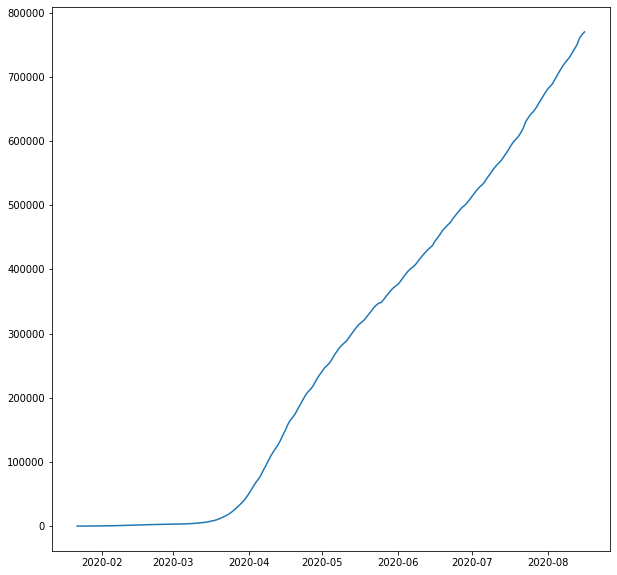

In [8]:
# plot the daily number of deaths
plt.figure(figsize = (10, 10))
plt.plot(dataset)

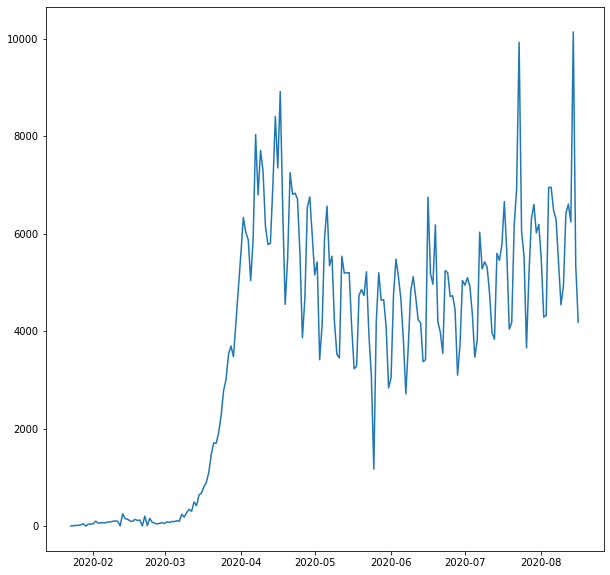

In [9]:
# plot the daily increase in deaths
plt.figure(figsize = (10, 10))
plt.plot(dataset.diff())

In [10]:
# create a new dataframe with the daily change in deaths
daily_deaths = dataset.diff()
daily_deaths

,y
ds,
2020-01-22,NaN
2020-01-23,1.0
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0
...,...
2020-08-12,6609.0
2020-08-13,6241.0
2020-08-14,10144.0


In [11]:
# remove the first 
daily_deaths = daily_deaths.loc['2020-01-23':'2020-08-13']
daily_deaths

,y
ds,
2020-01-23,1.0
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0
2020-01-27,26.0
...,...
2020-08-09,4542.0
2020-08-10,4931.0
2020-08-11,6419.0


In [14]:
# create a train and test set to run prediction analysis
start_date = '2020-07-31'

train = daily_deaths.loc[daily_deaths.index < pd.to_datetime(start_date)]
test = daily_deaths.loc[daily_deaths.index >= pd.to_datetime(start_date)]

In [16]:
# Create a MARIMAX model 
model = SARIMAX(train, order = (2, 1, 3))

In [17]:
# fit the model
fit = model.fit(disp = True)

In [18]:
# run the prediction
prediction = fit.predict(
    start = start_date, end = '2020-8-23', dynamic = False
)

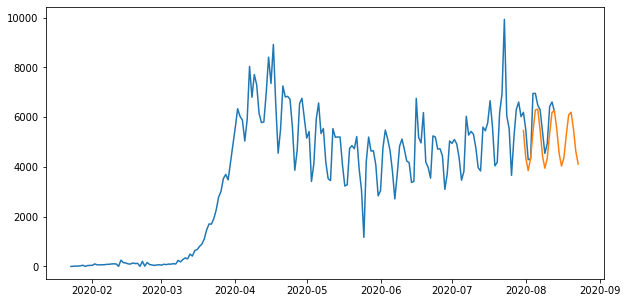

In [22]:
# plot the prediction
plt.figure(figsize = (10, 5))
l1 = plt.plot(daily_deaths, label = 'Observation')
l2 = plt.plot(prediction, label = 'ARIMA')

In [29]:
# find the mean absolute error
print('MAE = ', mean_absolute_error(prediction, test))

ValueError: Found input variables with inconsistent numbers of samples: [24, 14]

In [28]:
# find the best parameters for the model
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3,  # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3111.971, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3132.320, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3133.730, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3133.267, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3130.535, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3099.418, Time=0.65 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3128.118, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3089.597, Time=0.60 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3116.490, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3043.804, Time=0.85 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3040.433, Time=0.90 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3106.295, Time=0.57 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3025.719, Time=0.90 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3105.847, Time=0.64 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept